In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from numpy import array
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

In [2]:
dataset = pd.read_csv("Womens_Clothing_ECommerce_Reviews_Data.csv")

In [3]:
dataset.shape

(23486, 2)

In [4]:
dataset.head(5)

,Review Text,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


# Droping missing values

In [5]:
final_dataset = dataset.dropna(axis = 0, how = "any")

In [6]:
final_dataset.isnull().values.any()

False

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

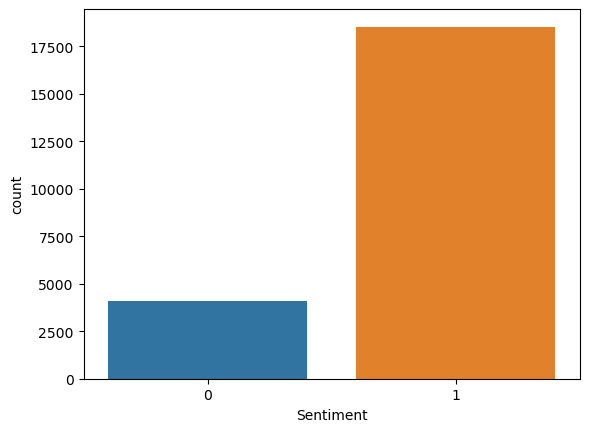

In [7]:
# Let's observe distribution of positive and negative sentiments in dataset
import seaborn as sns
sns.countplot(x='Sentiment', data=final_dataset)

In [8]:
# To see the punctuations, brackets, html tags and numbers
final_dataset["Review Text"] [10]

'Dress runs small esp where the zipper area runs. i ordered the sp which typically fits me and it was very tight! the material on the top looks and feels very cheap that even just pulling on it will cause it to rip the fabric. pretty disappointed as it was going to be my christmas dress this year! needless to say it will be going back.'

In [9]:
# preprocess this text
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    '''Remove HTML tags: replace anything between opening and closing <> with empty space'''
    
    return TAG_RE.sub('', text)

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def preprocess_text(sen):
    '''Clean text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower() 
    
    # Remove html tags
    sentence = remove_tags(sentence)
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Singal character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Remove Stopwords
    pattern = re.compile(r'\b(' +r'|'.join(stopwords.words('english')) + r')\b\s*')
    sencence = pattern.sub('', sentence)
    
    return sentence

In [12]:
# Preprocessing_text function on Review Text
x = []
sentences = list(final_dataset['Review Text']) 
for sen in sentences:
    x.append(preprocess_text(sen))

In [13]:
#Sample cleaned up Review Text
x[1]

'love this dress it sooo pretty happened to find it in store and m glad did bc never would have ordered it online bc it petite bought petite and am love the length on me hits just little below the knee would definitely be true midi on someone who is truly petite '

In [14]:
y = final_dataset['Sentiment']

In [15]:
# Separate train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [16]:
# Preparing Embedding Layer
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)

x_train_tokenizer = word_tokenizer.texts_to_sequences(x_train)
x_test_tokenizer = word_tokenizer.texts_to_sequences(x_test)

In [17]:
import io
import json

In [18]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [19]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

12404

In [20]:
max_len = 50
x_train = pad_sequences(x_train_tokenizer, maxlen = max_len)
x_test = pad_sequences(x_test_tokenizer, maxlen = max_len)

In [21]:
embedding_path = r"C:\Users\Admin\Desktop\Ecommerce_Sentiment_Analysis\crawl-300d-2M.vec"

In [22]:
embed_size = 300
max_features = 30000

In [23]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding="utf8"))

word_index = word_tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [24]:
embedding_matrix.shape

(12404, 300)

# Model Training with: Neural Networks

In [25]:
#Simple Neural Network architeccture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [26]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           3721200   
                                                                 
 flatten (Flatten)           (None, 15000)             0         
                                                                 
 dense (Dense)               (None, 1)                 15001     
                                                                 
Total params: 3,736,201
Trainable params: 15,001
Non-trainable params: 3,721,200
_________________________________________________________________
None


In [27]:
# Model training

snn_model_history = snn_model.fit(x_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
114/114 [==============================] - 5s 14ms/step - loss: 0.4003 - acc: 0.8264 - val_loss: 0.3761 - val_acc: 0.8283
Epoch 2/6
114/114 [==============================] - 1s 11ms/step - loss: 0.2937 - acc: 0.8718 - val_loss: 0.3546 - val_acc: 0.8435
Epoch 3/6
114/114 [==============================] - 1s 11ms/step - loss: 0.2496 - acc: 0.8973 - val_loss: 0.3528 - val_acc: 0.8421
Epoch 4/6
114/114 [==============================] - 1s 11ms/step - loss: 0.2206 - acc: 0.9145 - val_loss: 0.3577 - val_acc: 0.8443
Epoch 5/6
114/114 [==============================] - 1s 11ms/step - loss: 0.1978 - acc: 0.9257 - val_loss: 0.3609 - val_acc: 0.8429
Epoch 6/6
114/114 [==============================] - 1s 11ms/step - loss: 0.1807 - acc: 0.9364 - val_loss: 0.3592 - val_acc: 0.8457


In [28]:
# Predictions on the Test Set

score = snn_model.evaluate(x_test, y_test, verbose=1)

142/142 [==============================] - 1s 4ms/step - loss: 0.3383 - acc: 0.8563


In [29]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3382749855518341
Test Accuracy: 0.8562596440315247


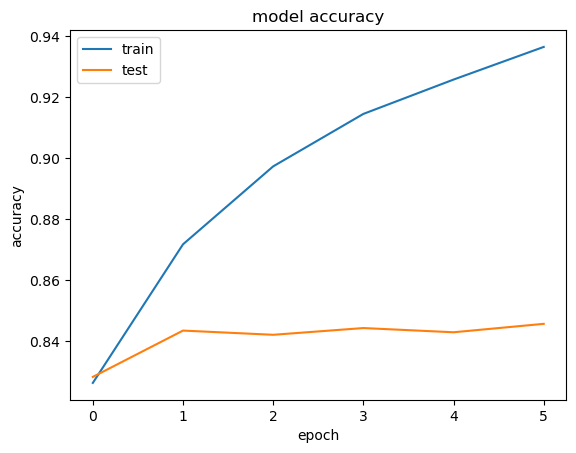

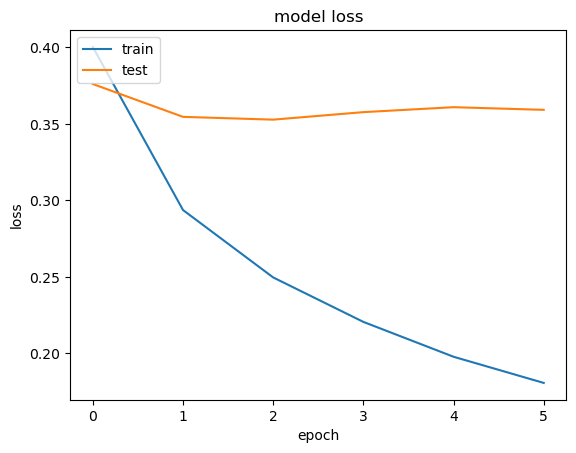

In [30]:
# Model Performance

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Convolutional Neural Network

In [31]:
from keras.layers import Conv1D 

In [32]:
# CNN Neural Network architeccture

cnn_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)

cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))


In [33]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 300)           3721200   
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           192128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,913,457
Trainable params: 192,257
Non-trainable params: 3,721,200
_________________________________________________________________
None


In [34]:
# Model training

cnn_model_history = cnn_model.fit(x_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
114/114 [==============================] - 17s 104ms/step - loss: 0.3643 - acc: 0.8373 - val_loss: 0.3145 - val_acc: 0.8523
Epoch 2/6
114/114 [==============================] - 12s 102ms/step - loss: 0.2430 - acc: 0.8964 - val_loss: 0.2950 - val_acc: 0.8592
Epoch 3/6
114/114 [==============================] - 12s 103ms/step - loss: 0.1897 - acc: 0.9228 - val_loss: 0.2772 - val_acc: 0.8755
Epoch 4/6
114/114 [==============================] - 12s 101ms/step - loss: 0.1471 - acc: 0.9493 - val_loss: 0.2748 - val_acc: 0.8763
Epoch 5/6
114/114 [==============================] - 12s 102ms/step - loss: 0.1087 - acc: 0.9700 - val_loss: 0.2780 - val_acc: 0.8783
Epoch 6/6
114/114 [==============================] - 12s 102ms/step - loss: 0.0778 - acc: 0.9844 - val_loss: 0.2843 - val_acc: 0.8774


In [35]:
# Predictions on the Test Set

score = cnn_model.evaluate(x_test, y_test, verbose=1)

142/142 [==============================] - 2s 14ms/step - loss: 0.2536 - acc: 0.8929


In [36]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.253584623336792
Test Accuracy: 0.8929123282432556


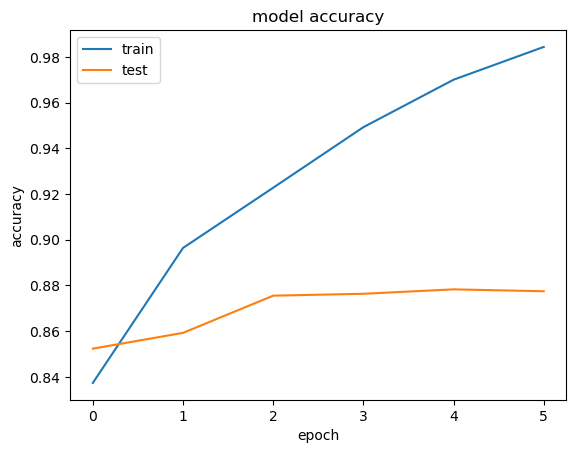

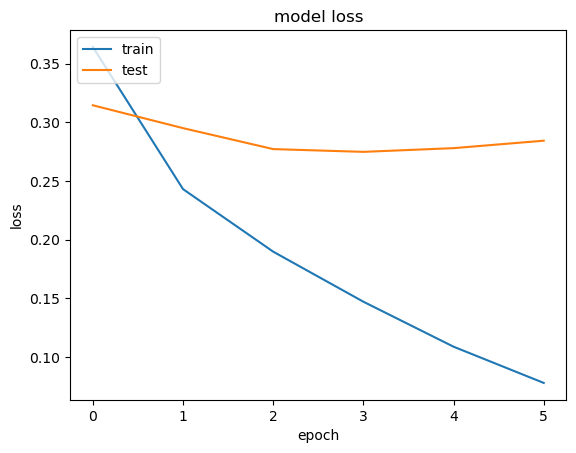

In [37]:
# Model Performance Chart

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Recurrent Neural Network(LSTM)

In [38]:
from keras.layers import LSTM

In [39]:
# LSTM Neural Network architeccture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))


In [40]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 300)           3721200   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,940,977
Trainable params: 219,777
Non-trainable params: 3,721,200
_________________________________________________________________
None


In [41]:
# Model training

lstm_model_history = lstm_model.fit(x_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
114/114 [==============================] - 29s 213ms/step - loss: 0.3561 - acc: 0.8474 - val_loss: 0.3502 - val_acc: 0.8567
Epoch 2/6
114/114 [==============================] - 23s 204ms/step - loss: 0.2809 - acc: 0.8785 - val_loss: 0.3381 - val_acc: 0.8614
Epoch 3/6
114/114 [==============================] - 23s 203ms/step - loss: 0.2662 - acc: 0.8836 - val_loss: 0.3097 - val_acc: 0.8703
Epoch 4/6
114/114 [==============================] - 23s 202ms/step - loss: 0.2422 - acc: 0.8956 - val_loss: 0.3062 - val_acc: 0.8711
Epoch 5/6
114/114 [==============================] - 23s 204ms/step - loss: 0.2311 - acc: 0.9036 - val_loss: 0.2954 - val_acc: 0.8730
Epoch 6/6
114/114 [==============================] - 23s 204ms/step - loss: 0.2160 - acc: 0.9077 - val_loss: 0.2983 - val_acc: 0.8774


In [42]:
# Predictions on the Test Set

score = lstm_model.evaluate(x_test, y_test, verbose=1)

142/142 [==============================] - 5s 37ms/step - loss: 0.2721 - acc: 0.8850


In [43]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.27207082509994507
Test Accuracy: 0.8849635720252991


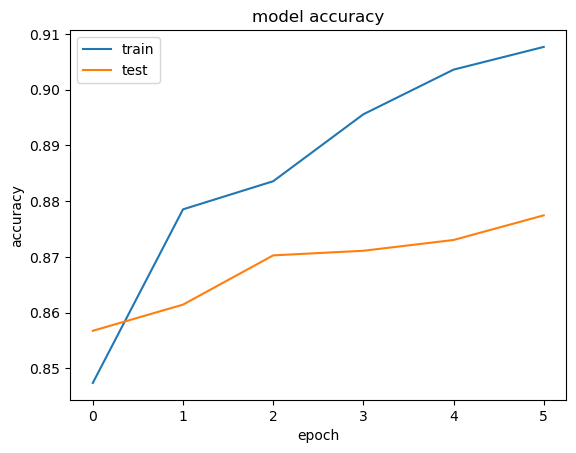

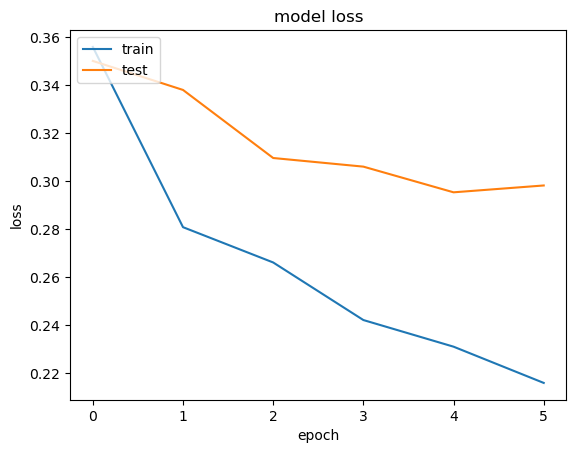

In [44]:
# Model Performance Chart

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./cl_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Making Prediction

In [46]:
# Load previously trained LSTM Model

from keras.models import load_model

model_path ='cl_lstm_model_acc_0.885.h5'
pretrained_lstm_model = load_model(model_path)

# summarize model.
pretrained_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 300)           3721200   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,940,977
Trainable params: 219,777
Non-trainable params: 3,721,200
_________________________________________________________________


In [47]:
df = pd.read_csv("Sample_Reviews_Womens_Clothing_ECommerce_Data.csv")

In [48]:
df.head(5)

,Clothing ID,Age,Review Text,Rating,Sentiment,Department Name,Class Name
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Intimate,Intimates
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,Dresses,Dresses
2,1077,60,I had such high hopes for this dress and reall...,3,0,Dresses,Dresses
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,Bottoms,Pants
4,847,47,This shirt is very flattering to all due to th...,5,1,Tops,Blouses


In [49]:
sample_reviews = df.dropna(axis = 0, how = "any")

In [50]:
# preprocess review text with earlier define preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
    review = preprocess_text(review)
    unseen_processed.append(review)

In [51]:
unseen_processed

['absolutely wonderful silky and sexy and comfortable',
 'love this dress it sooo pretty happened to find it in store and m glad did bc never would have ordered it online bc it petite bought petite and am love the length on me hits just little below the knee would definitely be true midi on someone who is truly petite ',
 'i had such high hopes for this dress and really wanted it to work for me initially ordered the petite small my usual size but found this to be outrageously small so small in fact that could not zip it up reordered it in petite medium which was just ok overall the top half was comfortable and fit nicely but the bottom half had very tight under layer and several somewhat cheap net over layers imo major design flaw was the net over layer sewn directly into the zipper it c',
 'i love love love this jumpsuit it fun flirty and fabulous every time wear it get nothing but great compliments ',
 'this shirt is very flattering to all due to the adjustable front tie it is the pe

In [54]:
from keras_preprocessing.text import tokenizer_from_json

In [55]:
# Loading
with open('b3_tokenizer.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [56]:
# Tokenising instant with earlier trained tokeniser
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_processed)


In [57]:
unseen_tokenized

[[249, 506, 839, 3, 626, 3, 65],
 [20,
  5,
  16,
  2,
  1609,
  98,
  1266,
  6,
  220,
  2,
  7,
  103,
  3,
  34,
  309,
  128,
  1178,
  397,
  40,
  23,
  51,
  2,
  136,
  1178,
  2,
  88,
  69,
  88,
  3,
  35,
  20,
  1,
  83,
  9,
  30,
  398,
  38,
  52,
  433,
  1,
  374,
  40,
  157,
  28,
  130,
  1294,
  9,
  412,
  419,
  4,
  734,
  88],
 [18,
  62,
  300,
  173,
  1037,
  10,
  5,
  16,
  3,
  49,
  187,
  2,
  6,
  100,
  10,
  30,
  1095,
  51,
  1,
  88,
  44,
  15,
  231,
  21,
  8,
  215,
  5,
  6,
  28,
  6825,
  44,
  14,
  44,
  7,
  651,
  17,
  113,
  19,
  711,
  2,
  41,
  2075,
  2,
  7,
  88,
  94,
  81,
  13,
  38,
  612,
  239,
  1,
  25,
  621,
  13,
  65,
  3,
  24,
  246,
  8,
  1,
  167,
  621,
  62,
  22,
  145,
  259,
  451,
  3,
  517,
  709,
  457,
  4072,
  151,
  911,
  1934,
  1737,
  137,
  1580,
  13,
  1,
  4072,
  151,
  451,
  752,
  3049,
  317,
  1,
  447,
  2,
  562],
 [18,
  20,
  20,
  20,
  5,
  609,
  2,
  276,
  1272,
  3,
  768,

In [58]:
# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=max_len)

In [59]:
unseen_padded

array([[ 249,  506,  839, ...,    0,    0,    0],
       [  16,    2, 1609, ...,    4,  734,   88],
       [2075,    2,    7, ...,  447,    2,  562],
       ...,
       [   5,   24,   58, ...,    0,    0,    0],
       [  87,    3,   33, ...,  106,  199,  180],
       [   5,   16,    7, ...,    0,    0,    0]])

In [60]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = pretrained_lstm_model.predict(unseen_padded)

unseen_sentiments

708/708 [==============================] - 27s 36ms/step


array([[0.9178971 ],
       [0.99579746],
       [0.26966125],
       ...,
       [0.44564316],
       [0.41254744],
       [0.9868228 ]], dtype=float32)

In [61]:
# Writing model output 

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_clothing_id           = pd.DataFrame(sample_reviews['Clothing ID'], columns = ['Clothing ID'])
df_rating                = pd.DataFrame(sample_reviews['Rating'], columns = ['Rating'])
df_age                   = pd.DataFrame(sample_reviews['Age'], columns = ['Age'])
df_department_name       = pd.DataFrame(sample_reviews['Department Name'], columns = ['Department Name'])
df_class_Name            = pd.DataFrame(sample_reviews['Class Name'], columns = ['Class Name'])

dfx=pd.concat([df_clothing_id, df_department_name, df_class_Name, df_age, df_review_text, df_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_Ecommerce_unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(5)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5012\549189343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)


,Clothing ID,Department Name,Class Name,Age,Review Text,Rating,Predicted Sentiments
0,767,Intimate,Intimates,33,Absolutely wonderful - silky and sexy and comf...,4,9.2
1,1080,Dresses,Dresses,34,Love this dress! it's sooo pretty. i happene...,5,10.0
2,1077,Dresses,Dresses,60,I had such high hopes for this dress and reall...,3,2.7
3,1049,Bottoms,Pants,50,"I love, love, love this jumpsuit. it's fun, fl...",5,9.9
4,847,Tops,Blouses,47,This shirt is very flattering to all due to th...,5,10.0


In [1]:
!pip install tensorflow==2.11.0

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tensorflow==2.0.0

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0rc0, 2.12.0rc1)
ERROR: No matching distribution found for tensorflow==2.0.0


In [53]:
!pip install Keras-Preprocessing

Defaulting to user installation because normal site-packages is not writeable
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
